In [1]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import select
import time
import re
import os

def start_server(error_rate, num_pages, fanout, level_policy, port):
    cmd = f"./bin/server -e {error_rate} -n {num_pages} -f {fanout} -l {level_policy} -p {port}"
    server_process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return server_process

def stop_server(server_process):
    server_process.terminate()


In [2]:
def wait_for_server_ready(server_process):
    start_time = time.time()
    timeout = 10  # Timeout in seconds

    while True:
        ready, _, _ = select.select([server_process.stdout], [], [], timeout)
        if ready:
            output_line = server_process.stdout.readline().decode()
            print(output_line, end="")
            if "New client connected" in output_line:
                break
        elif time.time() - start_time > timeout:
            raise TimeoutError("Server did not print 'New client connected' within the timeout period.")

def run_experiment(port, workload_path):
    client_cmd = f'./bin/client -p {port}'
    
    # Start the client process
    client_process = subprocess.Popen(client_cmd.split(), stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    
    # Wait for the server to print "New client connected"
    try:
        wait_for_server_ready(server_process)
    except TimeoutError as e:
        print(e)
        client_process.terminate()
        return None

    # Run the benchmark command
    benchmark_cmd = f'b {workload_path}\n'
    client_process.stdin.write(benchmark_cmd.encode())
    client_process.stdin.flush()

    time_taken = None
    while True:
        # Wait for output from the server process
        ready, _, _ = select.select([server_process.stdout], [], [], 1)  # 1 second timeout
        if ready:
            output_line = server_process.stdout.readline().decode()
            print(output_line, end="")
            match = re.search(r'(\d+) microseconds', output_line)
            if match:
                time_taken = int(match.group(1))
                break

    client_process.terminate()
    return time_taken


In [3]:
params = {
    'error_rate': [0.01, 0.05],
    'num_pages': [512, 1024],
    'fanout': [5, 10],
    'level_policy': ['LAZY_LEVELED', 'LEVELED', 'TIERED'],
    'port': 1249
}

results = []

for error_rate, num_pages, fanout, level_policy in itertools.product(params['error_rate'], params['num_pages'], params['fanout'], params['level_policy']):
    server_process = start_server(error_rate, num_pages, fanout, level_policy, params['port'])
    time_taken = run_experiment(params['port'], 'workload.txt')
    stop_server(server_process)

    result = {
        'error_rate': error_rate,
        'num_pages': num_pages,
        'fanout': fanout,
        'level_policy': level_policy,
        'time_taken': time_taken
    }
    results.append(result)

results_df = pd.DataFrame(results)



Server started, listening on port 1249
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 1048576
  LSM-tree fanout: 5
  Level policy: LAZY_LEVELED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt file took 191872 microseconds (0 minutes, 0.19 seconds)

Server started, listening on port 1249
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 1048576
  LSM-tree fanout: 5
  Level policy: LEVELED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt file took 173120 microseconds (0 minutes, 0.17 seconds)

Server started, listening on port 1249
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 1048576
  LSM-tree fanout: 5
  Level policy: TIERED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.

In [4]:
results_df

,error_rate,num_pages,fanout,level_policy,time_taken
0,0.01,512,5,LAZY_LEVELED,191872
1,0.01,512,5,LEVELED,173120
2,0.01,512,5,TIERED,213538
3,0.01,512,10,LAZY_LEVELED,181570
4,0.01,512,10,LEVELED,171937
5,0.01,512,10,TIERED,209855
6,0.01,1024,5,LAZY_LEVELED,185115
7,0.01,1024,5,LEVELED,184467
8,0.01,1024,5,TIERED,190572
9,0.01,1024,10,LAZY_LEVELED,187681


In [5]:
for error_rate in params['error_rate']:
    for level_policy in params['level_policy']:
        # Filter the data for the current error rate and level policy combination
        data = results_df[(results_df['error_rate'] == error_rate) & (results_df['level_policy'] == level_policy)]


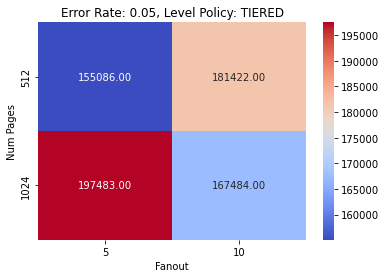

In [6]:
# Create a heatmap of time taken with varying num_pages and fanout values
pivot_table = data.pivot_table(values='time_taken', index='num_pages', columns='fanout')
ax = sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='coolwarm')

# Set plot title and labels
ax.set_title(f'Error Rate: {error_rate}, Level Policy: {level_policy}')
ax.set_xlabel('Fanout')
ax.set_ylabel('Num Pages')

# Show the plot
plt.show()
